In [1]:
# -*- coding: utf8


from scipy.special import gammaln
from scipy.special import psi


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import sys

In [2]:
def init_matplotlib():
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['font.family'] = 'serif'
    plt.style.use('tableau-colorblind10')
    
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [3]:
init_matplotlib()
plt.ion()

In [4]:
sys.path.append('../py-code')
import amutils

In [5]:
allmusic_json = amutils.load_am_json_data()

In [6]:
names = {}
for key, val in allmusic_json.items():
    names[key] = val['name']

In [7]:
def load_centralities(fpath):
    df = pd.read_csv(fpath, index_col=0)
    new_index = []
    if 'allmusic' in fpath:
        for id_ in df.index:
            new_index.append(names[id_])
        df.index = pd.Index(new_index)
    
    node2id = {}
    id2node = {}
    for artist_id in df.index:
        key = artist_id
        if key in node2id:
            key = '{}-2nd-entry'.format(key)
        node2id[artist_id] = len(node2id)
        id2node[node2id[artist_id]] = artist_id
    
    delta = int(df.columns[1]) - int(df.columns[0])
    return df.sort_index(), node2id, id2node, delta

In [8]:
def get_rank_positions(decade, node2id, df_centrality):
    n = len(node2id)
    aux = np.zeros(n)
    for node, value in df_centrality[str(decade)].iteritems():
        if np.isnan(value):
            aux[node2id[node]] = -np.inf
        else:
            aux[node2id[node]] = value
    
    ranks = ss.rankdata(aux, method='max')
    
    values = np.zeros(shape=(2, n), dtype='d')
    values[0] = n - ranks # number above
    values[1] = ranks     # number below
    
    return values.T + 1   # +1 to avoid zeroes

In [9]:
def rank_surprise_detector(observed, prior):
    '''
    Computes the rank based surprise.
    
    Arguments
    ---------
    observed: matrix with the number of nodes with centrality
              values greater then (observed[i][0]) or lower
              then (observed[i][1]) node i.
    prior:    The prior for each node. prior[i][0] is alpha, and
              prior[i][1] is beta. In our paper, we set the prior
              for each such that prior[i][0] / sum(prior[i])
              captures the fraction of other nodes with centrality
              greater than node i.
    
    Both arguments are o shape (n_nodes, 2). Organizing data like
    this make's it easy to compute the posterior = observed + prior.
    
    Returns
    -------
    The posterior and the surprise for each node
    
    References
    ----------
    
    [1]  Penny  WD  (2001):  “KL-Divergences  of  Normal,
         Gamma,  Dirichlet  and  Wishartdensities”.
         University College, London;
         URL: www.fil.ion.ucl.ac.uk/∼wpenny/publications/densities.ps.
    [2]  Kullback-Leibler Divergence Between Two Dirichlet
         (and Beta) Distributions. URL: http://bariskurt.com/
    '''
    posterior = prior + observed
    prior = (prior.T / prior.sum(axis=1)).T
    posterior = (posterior.T / posterior.sum(axis=1)).T
    
    # from here the code is a dkl divergence of dirichlets. adapted and double
    # checked [1] and [2]
    
    d_obs = gammaln(posterior.sum(axis=1)) - np.sum(gammaln(posterior), axis=1)
    d_pri = gammaln(prior.sum(axis=1)) - np.sum(gammaln(prior), axis=1)
    individual_factors = (posterior - prior).T * \
            (psi(posterior).T - psi(posterior.sum(axis=1)))
    surprises = d_obs - d_pri + individual_factors.sum(axis=0)
    
    return prior, posterior, surprises

In [10]:
def hypothesis_past(year, delta, node2id, df):
    return get_rank_positions(year - delta, node2id, df)

def hypothesis_growth(year, delta, node2id, df):
    position_2d_ago = get_rank_positions(year - 2 * delta, node2id, df)
    position_1d_ago = get_rank_positions(year - delta, node2id, df)
    prior = position_1d_ago * (position_1d_ago / position_2d_ago)
    return prior

def hypothesis_flat(year, delta, node2id, df):
    prior = get_rank_positions(year, node2id, df) # just to get the shape
    prior[:] = 1.0
    return prior

In [11]:
df, node2id, id2node, delta = load_centralities('../centrality-csvs/allmusic_pageranks.csv')
for year in map(int, df.columns[2:]):
    obs = get_rank_positions(year, node2id, df)
    prior, posterior, surprises = \
            rank_surprise_detector(obs,
                                   hypothesis_past(year,
                                                   delta,
                                                   node2id,
                                                   df))
    
    print(year, ' mean surprise ->', surprises.mean())
    top = surprises.argsort()[-5:][::-1]
    for ni in top:
        p = obs[ni][0] / obs[ni].sum()
        beta = ss.beta(a=posterior[ni][0], b=posterior[ni][1])
        print(year-delta, year, id2node[ni],
              surprises[ni],
              beta.pdf(p),
              sep='\t')
    print()

1960  mean surprise -> 0.05010772274428803
1950	1960	The Beatles	0.3065740069263132	110.16233081597566
1950	1960	Lesley Riddle	0.3053772938519095	81.26743618483815
1950	1960	Bob Dylan	0.2955698858121396	26.29367120479838
1950	1960	The Rolling Stones	0.2890660496829053	18.245887730295088
1950	1960	Jimi Hendrix	0.2771747734884318	11.718697788419

1970  mean surprise -> 0.024036543832729764
1960	1970	Sex Pistols	0.2875180044409835	11.178417683465367
1960	1970	Kraftwerk	0.27240452285612515	7.5118533421212055
1960	1970	Ramones	0.27142277701639705	7.355615046758072
1960	1970	New York Dolls	0.26772089791398035	6.820777966961386
1960	1970	Roxy Music	0.2655983447875664	6.547788564383392

1980  mean surprise -> 0.025751306964096242
1970	1980	R.E.M.	0.29478677396482433	8.147627614694192
1970	1980	Metallica	0.2856108327691803	6.575022527035498
1970	1980	Run-D.M.C.	0.2846670625567569	6.447785779757317
1970	1980	Minor Threat	0.2701964662941122	4.978696654532883
1970	1980	N.W.A	0.2566254558534309	4.1

2000 -> 2010


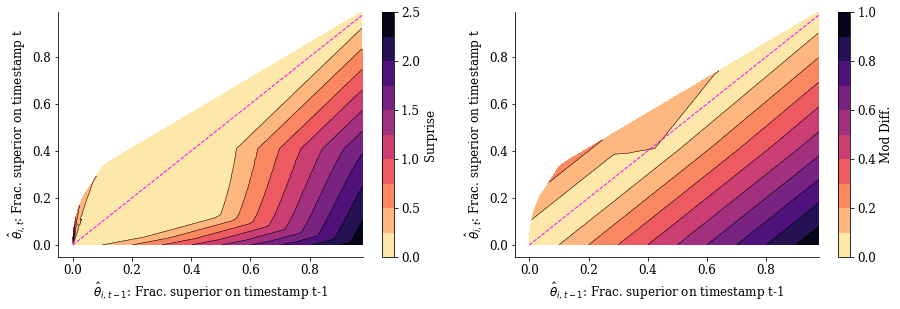

In [12]:
for decade in map(int, df.columns[-1:]):
    print('{} -> {}'.format(decade-delta, decade))
        
    fig, axes = plt.subplots(1, 2, figsize=(15, 4.5))
    
    prior = hypothesis_growth(decade, delta, node2id, df)
    obs = get_rank_positions(decade, node2id, df)
    surprises = rank_surprise_detector(obs, prior)[-1]
    
    prev = prior[:, 0] / prior.sum(axis=1)
    new = obs[:, 0] / obs.sum(axis=1)
    
    y = new
    x = prev
    z = surprises
    
    axes[0].tricontour(x, y, surprises, levels=10, linewidths=0.5, colors='k')
    im = axes[0].tricontourf(x, y, surprises, levels=10, cmap='magma_r')

    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label('Surprise')

    l = np.linspace(0, min(x.max(), y.max()), 10)
    axes[0].plot(l, l, '--', color='magenta', lw=1)
    axes[0].set_xlabel(r'$\hat{\theta}_{i, t-1}$: Frac. superior on timestamp t-1')
    axes[0].set_ylabel(r'$\hat{\theta}_{i, t}$: Frac. superior on timestamp t')
    despine(axes[0])
    
    axes[1].tricontour(x, y, np.abs(x-y), levels=10, linewidths=0.5, colors='k')
    im = axes[1].tricontourf(x, y, np.abs(x-y), levels=10, cmap='magma_r')    
    cbar = fig.colorbar(im, ax=axes[1])
    cbar.set_label('Mod Diff.')
    
    l = np.linspace(0, min(x.max(), y.max()), 10)
    axes[1].plot(l, l, '--', color='magenta', lw=1)
    axes[1].set_xlabel(r'$\hat{\theta}_{i, t-1}$: Frac. superior on timestamp t-1')
    axes[1].set_ylabel(r'$\hat{\theta}_{i, t}$: Frac. superior on timestamp t')
    despine(axes[1])

## Generate CSVs for Paper from Here

From here it's just one big script to generate the csvs used for results in the paper.

In [14]:
df_pagerank, node2id_pagerank, id2node_pagerank, _ = \
        load_centralities('../centrality-csvs/allmusic_pageranks.csv')
df_disrupt, node2id_disrupt, id2node_disrupt, delta = \
        load_centralities('../centrality-csvs/allmusic_disruption.csv')

#df_pagerank = df_pagerank.iloc[:-1]
#df_disrupt = df_disrupt.iloc[:-1]

assert len(df_pagerank) == len(df_disrupt)
for i in range(len(df_pagerank)):
    assert df_pagerank.index[i] == df_disrupt.index[i]

In [21]:
rv = {'name' : [],
      'year': [],

      'pagerank_obs_curr_t_nabove': [],
      'pagerank_obs_curr_t_nbelow': [],

      'pagerank_prior_hyp_past_t_alpha': [],
      'pagerank_prior_hyp_past_t_beta': [],
      'pagerank_posterior_hyp_past_t_alpha': [],
      'pagerank_posterior_hyp_past_t_beta': [],
      'pagerank_surprise_hyp_past_t': [],

      'pagerank_prior_hyp_growth_t_alpha': [],
      'pagerank_prior_hyp_growth_t_beta': [],
      'pagerank_posterior_hyp_growth_t_alpha': [],
      'pagerank_posterior_hyp_growth_t_beta': [],
      'pagerank_surprise_hyp_growth_t': [],
      
      'disrupt_obs_curr_t_nabove': [],
      'disrupt_obs_curr_t_nbelow': [],
      
      'disrupt_prior_hyp_past_t_alpha': [],
      'disrupt_prior_hyp_past_t_beta': [],
      'disrupt_posterior_hyp_past_t_alpha': [],
      'disrupt_posterior_hyp_past_t_beta': [],
      'disrupt_surprise_hyp_past_t': [],
      
      'disrupt_prior_hyp_growth_t_alpha': [],
      'disrupt_prior_hyp_growth_t_beta': [],
      'disrupt_posterior_hyp_growth_t_alpha': [],
      'disrupt_posterior_hyp_growth_t_beta': [],
      'disrupt_surprise_hyp_growth_t': []
     
     }

for year in map(int, df_pagerank.columns[2:]):
    obs_pagerank = get_rank_positions(year, node2id_pagerank, df_pagerank)
    rv['name'].extend([id2node[i] for i in range(len(obs_pagerank))])
    rv['year'].extend([year for _ in range(len(obs_pagerank))])
    
    prior_past, posterior_past, surprises_past = \
            rank_surprise_detector(obs_pagerank,
                                   hypothesis_past(year,
                                                   delta,
                                                   node2id_pagerank,
                                                   df_pagerank))
    
    prior_growth, posterior_growth, surprises_growth = \
            rank_surprise_detector(obs_pagerank,
                                   hypothesis_past(year,
                                                   delta,
                                                   node2id_pagerank,
                                                   df_pagerank))
    
    rv['pagerank_obs_curr_t_nabove'].extend(obs_pagerank[:, 0])
    rv['pagerank_obs_curr_t_nbelow'].extend(obs_pagerank[:, 1])
    
    rv['pagerank_prior_hyp_past_t_alpha'].extend(prior_past[:, 0])
    rv['pagerank_prior_hyp_past_t_beta'].extend(prior_past[:, 1])
    rv['pagerank_posterior_hyp_past_t_alpha'].extend(posterior_past[:, 0])
    rv['pagerank_posterior_hyp_past_t_beta'].extend(posterior_past[:, 1])
    rv['pagerank_surprise_hyp_past_t'].extend(surprises_past)
    
    rv['pagerank_prior_hyp_growth_t_alpha'].extend(prior_growth[:, 0])
    rv['pagerank_prior_hyp_growth_t_beta'].extend(prior_growth[:, 1])
    rv['pagerank_posterior_hyp_growth_t_alpha'].extend(posterior_growth[:, 0])
    rv['pagerank_posterior_hyp_growth_t_beta'].extend(posterior_growth[:, 1])
    rv['pagerank_surprise_hyp_growth_t'].extend(surprises_growth)
    
    
    obs_disrupt = get_rank_positions(year, node2id_disrupt, df_disrupt)
    prior_past, posterior_past, surprises_past = \
            rank_surprise_detector(obs_disrupt,
                                   hypothesis_past(year,
                                                   delta,
                                                   node2id_disrupt,
                                                   df_disrupt))
    
    prior_growth, posterior_growth, surprises_growth = \
            rank_surprise_detector(obs_disrupt,
                                   hypothesis_past(year,
                                                   delta,
                                                   node2id_disrupt,
                                                   df_disrupt))
    
    rv['disrupt_obs_curr_t_nabove'].extend(obs_disrupt[:, 0])
    rv['disrupt_obs_curr_t_nbelow'].extend(obs_disrupt[:, 1])
    
    rv['disrupt_prior_hyp_past_t_alpha'].extend(prior_past[:, 0])
    rv['disrupt_prior_hyp_past_t_beta'].extend(prior_past[:, 1])
    rv['disrupt_posterior_hyp_past_t_alpha'].extend(posterior_past[:, 0])
    rv['disrupt_posterior_hyp_past_t_beta'].extend(posterior_past[:, 1])
    rv['disrupt_surprise_hyp_past_t'].extend(surprises_past)
    
    rv['disrupt_prior_hyp_growth_t_alpha'].extend(prior_growth[:, 0])
    rv['disrupt_prior_hyp_growth_t_beta'].extend(prior_growth[:, 1])
    rv['disrupt_posterior_hyp_growth_t_alpha'].extend(posterior_growth[:, 0])
    rv['disrupt_posterior_hyp_growth_t_beta'].extend(posterior_growth[:, 1])
    rv['disrupt_surprise_hyp_growth_t'].extend(surprises_growth)

In [22]:
rv = pd.DataFrame(rv)
rv.to_csv('allmusic_surprises.csv', index=False)